# Read Data Sample

In [1]:
import pandas as pd
import numpy as np
from collections import namedtuple
pd.set_option("display.max_rows",35)
%matplotlib inline

In [2]:
class dataset:
    kdd_train_2labels = pd.read_pickle("dataset/kdd_train_2labels.pkl")
    kdd_test_2labels = pd.read_pickle("dataset/kdd_test_2labels.pkl")
    
    kdd_train_5labels = pd.read_pickle("dataset/kdd_train_5labels.pkl")
    kdd_test_5labels = pd.read_pickle("dataset/kdd_test_5labels.pkl")
    

In [3]:
dataset.kdd_train_2labels.shape

(125973, 124)

In [4]:
dataset.kdd_test_2labels.shape

(22544, 124)

In [5]:
from sklearn import model_selection as ms
from sklearn import preprocessing as pp

class preprocess:
    
    output_columns_2labels = ['is_Attack','is_Normal']
    
    x_input = dataset.kdd_train_2labels.drop(output_columns_2labels, axis = 1)
    y_output = dataset.kdd_train_2labels.loc[:,output_columns_2labels]

    x_test_input = dataset.kdd_test_2labels.drop(output_columns_2labels, axis = 1)
    y_test = dataset.kdd_test_2labels.loc[:,output_columns_2labels]

    ss = pp.StandardScaler()

    x_train = ss.fit_transform(x_input)
    x_test = ss.transform(x_test_input)

    y_train = y_output.values
    y_test = y_test.values

preprocess.x_train.shape

(125973, 122)

In [6]:
import tensorflow as tf


In [7]:
class network(object):
    
    input_dim = 122
    classes = 2
    hidden_encoder_dim = 122
    hidden_layers = 1
    latent_dim = 18

    def __init__(self, classes, hidden_layers, num_of_features):
        self.classes = classes
        self.hidden_layers = hidden_layers
        self.latent_dim = num_of_features
            
    def build_layers(self):
        tf.reset_default_graph()
        #learning_rate = tf.Variable(initial_value=0.001)

        input_dim = self.input_dim
        classes = self.classes
        hidden_encoder_dim = self.hidden_encoder_dim
        hidden_layers = self.hidden_layers
        latent_dim = self.latent_dim
        
        with tf.variable_scope("Input"):
            self.x = tf.placeholder("float", shape=[None, input_dim])
            self.y_ = tf.placeholder("float", shape=[None, classes])
            self.keep_prob = tf.placeholder("float")
        
        with tf.variable_scope("Layer_Encoder"):

            hidden_encoder = tf.layers.dense(self.x, hidden_encoder_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            for h in range(hidden_layers - 1):
                hidden_encoder = tf.layers.dense(hidden_encoder, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
                hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
            #hidden_encoder = tf.layers.dense(self.x, latent_dim, activation = tf.nn.relu, kernel_regularizer=tf.nn.l2_loss)
            #hidden_encoder = tf.nn.dropout(hidden_encoder, self.keep_prob)
            
        with tf.variable_scope("Layer_Dense_Softmax"):
            self.y = tf.layers.dense(hidden_encoder, classes, activation=tf.nn.softmax)
            
        with tf.variable_scope("Loss"):
            
            loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = self.y_, logits = self.y))

            #loss = tf.clip_by_value(loss, -1e-1, 1e-1)
            #loss = tf.where(tf.is_nan(loss), 1e-1, loss)
            #loss = tf.where(tf.equal(loss, -1e-1), tf.random_normal(loss.shape), loss)
            #loss = tf.where(tf.equal(loss, 1e-1), tf.random_normal(loss.shape), loss)
            
            self.regularized_loss = loss
            correct_prediction = tf.equal(tf.argmax(self.y_, 1), tf.argmax(self.y, 1))
            self.tf_accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name = "Accuracy")

        with tf.variable_scope("Optimizer"):
            learning_rate=1e-5
            optimizer = tf.train.AdamOptimizer(learning_rate)
            gradients, variables = zip(*optimizer.compute_gradients(self.regularized_loss))
            gradients = [
                None if gradient is None else tf.clip_by_value(gradient, -1, 1)
                for gradient in gradients]
            self.train_op = optimizer.apply_gradients(zip(gradients, variables))
            #self.train_op = optimizer.minimize(self.regularized_loss)
            
        # add op for merging summary
        #self.summary_op = tf.summary.merge_all()
        self.pred = tf.argmax(self.y, axis = 1)
        self.actual = tf.argmax(self.y_, axis = 1)

        # add Saver ops
        self.saver = tf.train.Saver()
        

In [8]:
import collections

class Train:    
    
    result = namedtuple("score", ['epoch', 'no_of_features','hidden_layers','train_score', 'test_score'])

    predictions = {}

    results = []
    best_acc = 0
    
    def train(epochs, net, h,f):
        batch_iterations = 200
        train_loss = None
        Train.best_acc = 0
        with tf.Session() as sess:
            #summary_writer_train = tf.summary.FileWriter('./logs/kdd/VAE/training', graph=sess.graph)
            #summary_writer_valid = tf.summary.FileWriter('./logs/kdd/VAE/validation')

            sess.run(tf.global_variables_initializer())

            for epoch in range(1, (epochs+1)):
                x_train, x_valid, y_train, y_valid, = ms.train_test_split(preprocess.x_train, 
                                                                          preprocess.y_train, 
                                                                          test_size=0.1)
                batch_indices = np.array_split(np.arange(x_train.shape[0]), 
                                           batch_iterations)
                                                                          
                for i in batch_indices:
                    
                    def train_batch():
                        nonlocal train_loss
                        _, train_loss = sess.run([net.train_op, 
                                                           net.regularized_loss, 
                                                           ], #net.summary_op
                                                          feed_dict={net.x: x_train[i,:], 
                                                                     net.y_: y_train[i,:], 
                                                                     net.keep_prob:0.5})
                    
                    train_batch()
                    #summary_writer_train.add_summary(summary_str, epoch)
                    while((train_loss > 1e4 or np.isnan(train_loss)) and epoch > 1):
                        print("Step {} | Training Loss: {:.6f}".format(epoch, train_loss))
                        net.saver.restore(sess, 
                                          tf.train.latest_checkpoint('dataset/tf_vae_dense_trained_together_nsl_kdd/hidden layers_{}_features count_{}'
                                                                     .format(epochs,h,f)))
                        train_batch()
                    

                valid_accuracy = sess.run(net.tf_accuracy, #net.summary_op 
                                                      feed_dict={net.x: x_valid, 
                                                                 net.y_: y_valid, 
                                                                 net.keep_prob:1})
                #summary_writer_valid.add_summary(summary_str, epoch)

                
                accuracy, pred_value, actual_value, y_pred = sess.run([net.tf_accuracy, 
                                                               net.pred, 
                                                               net.actual, net.y], 
                                                              feed_dict={net.x: preprocess.x_test, 
                                                                         net.y_: preprocess.y_test, 
                                                                         net.keep_prob:1})

                print("Step {} | Training Loss: {:.6f} | Validation Accuracy: {:.6f}".format(epoch, train_loss, valid_accuracy))
                print("Accuracy on Test data: {}".format(accuracy))

                if accuracy > Train.best_acc:
                    Train.best_acc = accuracy
                    Train.pred_value = pred_value
                    Train.actual_value = actual_value
                    Train.best_parameters = "Hidden Layers:{}, Features Count:{}".format(h, f)
                    if not (np.isnan(train_loss)):
                        net.saver.save(sess, 
                                   "dataset/tf_dense_only_nsl_kdd_hidden layers_{}_features count_{}".format(h,f),
                                    global_step = epochs)
                    curr_pred = pd.DataFrame({"Attack_prob":y_pred[:,-2], "Normal_prob":y_pred[:, -1], "Prediction":pred_value})
                    Train.predictions.update({"{}_{}_{}".format(epochs,f,h):(curr_pred, 
                                               Train.result(epochs, f, h,valid_accuracy, accuracy))})

                    #Train.results.append(Train.result(epochs, f, h,valid_accuracy, accuracy))
            

In [9]:
import itertools
class Hyperparameters:
#    features_arr = [2, 4, 8, 16, 32, 64, 128, 256]
#    hidden_layers_arr = [2, 4, 6, 10]
    features_arr = [4, 8, 32, 64]
    hidden_layers_arr = [2, 4, 6]

    epochs = [100]
    
    for e, h, f in itertools.product(epochs, hidden_layers_arr, features_arr):
        print("Current Layer Attributes - epochs:{} hidden layers:{} features count:{}".format(e,h,f))
        n = network(2,h,f)
        n.build_layers()
        Train.train(e, n, h,f)
        

Current Layer Attributes - epochs:100 hidden layers:2 features count:4
Step 1 | Training Loss: 0.742751 | Validation Accuracy: 0.600095
Accuracy on Test data: 0.6329400539398193
Step 2 | Training Loss: 0.667603 | Validation Accuracy: 0.661454
Accuracy on Test data: 0.7025816440582275
Step 3 | Training Loss: 0.671434 | Validation Accuracy: 0.782823
Accuracy on Test data: 0.7355837225914001
Step 4 | Training Loss: 0.608628 | Validation Accuracy: 0.822988
Accuracy on Test data: 0.755189836025238
Step 5 | Training Loss: 0.612805 | Validation Accuracy: 0.858946
Accuracy on Test data: 0.7675656676292419
Step 6 | Training Loss: 0.605621 | Validation Accuracy: 0.889030
Accuracy on Test data: 0.7836675047874451
Step 7 | Training Loss: 0.588425 | Validation Accuracy: 0.902921
Accuracy on Test data: 0.7961320281028748
Step 8 | Training Loss: 0.566084 | Validation Accuracy: 0.912367
Accuracy on Test data: 0.8045599460601807
Step 9 | Training Loss: 0.552503 | Validation Accuracy: 0.927131
Accuracy 

Step 77 | Training Loss: 0.420339 | Validation Accuracy: 0.973250
Accuracy on Test data: 0.7613112330436707
Step 78 | Training Loss: 0.409789 | Validation Accuracy: 0.973726
Accuracy on Test data: 0.7610894441604614
Step 79 | Training Loss: 0.446931 | Validation Accuracy: 0.973091
Accuracy on Test data: 0.7610450387001038
Step 80 | Training Loss: 0.424310 | Validation Accuracy: 0.973488
Accuracy on Test data: 0.7607789039611816
Step 81 | Training Loss: 0.417343 | Validation Accuracy: 0.973091
Accuracy on Test data: 0.7603353261947632
Step 82 | Training Loss: 0.434642 | Validation Accuracy: 0.973885
Accuracy on Test data: 0.7603797316551208
Step 83 | Training Loss: 0.436632 | Validation Accuracy: 0.971265
Accuracy on Test data: 0.7602022886276245
Step 84 | Training Loss: 0.408524 | Validation Accuracy: 0.972059
Accuracy on Test data: 0.7601579427719116
Step 85 | Training Loss: 0.422157 | Validation Accuracy: 0.974996
Accuracy on Test data: 0.7600248456001282
Step 86 | Training Loss: 0.4

Step 53 | Training Loss: 0.358358 | Validation Accuracy: 0.974043
Accuracy on Test data: 0.7613555788993835
Step 54 | Training Loss: 0.373868 | Validation Accuracy: 0.972377
Accuracy on Test data: 0.7607789039611816
Step 55 | Training Loss: 0.364563 | Validation Accuracy: 0.971980
Accuracy on Test data: 0.7597143650054932
Step 56 | Training Loss: 0.373992 | Validation Accuracy: 0.972773
Accuracy on Test data: 0.7591820359230042
Step 57 | Training Loss: 0.366219 | Validation Accuracy: 0.972218
Accuracy on Test data: 0.7585166692733765
Step 58 | Training Loss: 0.362949 | Validation Accuracy: 0.972773
Accuracy on Test data: 0.7579400539398193
Step 59 | Training Loss: 0.378503 | Validation Accuracy: 0.969281
Accuracy on Test data: 0.7575851678848267
Step 60 | Training Loss: 0.381886 | Validation Accuracy: 0.971345
Accuracy on Test data: 0.7567867040634155
Step 61 | Training Loss: 0.365755 | Validation Accuracy: 0.973329
Accuracy on Test data: 0.7562544345855713
Step 62 | Training Loss: 0.3

Step 29 | Training Loss: 0.367783 | Validation Accuracy: 0.967614
Accuracy on Test data: 0.7863289713859558
Step 30 | Training Loss: 0.348583 | Validation Accuracy: 0.970233
Accuracy on Test data: 0.785397469997406
Step 31 | Training Loss: 0.354465 | Validation Accuracy: 0.971583
Accuracy on Test data: 0.7831795811653137
Step 32 | Training Loss: 0.361720 | Validation Accuracy: 0.969995
Accuracy on Test data: 0.7800301909446716
Step 33 | Training Loss: 0.369527 | Validation Accuracy: 0.971900
Accuracy on Test data: 0.7796309590339661
Step 34 | Training Loss: 0.345822 | Validation Accuracy: 0.969598
Accuracy on Test data: 0.7790542840957642
Step 35 | Training Loss: 0.355479 | Validation Accuracy: 0.969916
Accuracy on Test data: 0.7781227827072144
Step 36 | Training Loss: 0.353759 | Validation Accuracy: 0.970154
Accuracy on Test data: 0.7776792049407959
Step 37 | Training Loss: 0.352143 | Validation Accuracy: 0.971980
Accuracy on Test data: 0.7770581841468811
Step 38 | Training Loss: 0.34

Step 5 | Training Loss: 0.514762 | Validation Accuracy: 0.908081
Accuracy on Test data: 0.8643097877502441
Step 6 | Training Loss: 0.476807 | Validation Accuracy: 0.919670
Accuracy on Test data: 0.851934015750885
Step 7 | Training Loss: 0.464102 | Validation Accuracy: 0.929671
Accuracy on Test data: 0.8376951813697815
Step 8 | Training Loss: 0.441739 | Validation Accuracy: 0.943166
Accuracy on Test data: 0.8256742358207703
Step 9 | Training Loss: 0.432873 | Validation Accuracy: 0.950627
Accuracy on Test data: 0.8207505345344543
Step 10 | Training Loss: 0.418528 | Validation Accuracy: 0.955310
Accuracy on Test data: 0.813342809677124
Step 11 | Training Loss: 0.425484 | Validation Accuracy: 0.956898
Accuracy on Test data: 0.8082860112190247
Step 12 | Training Loss: 0.409323 | Validation Accuracy: 0.961581
Accuracy on Test data: 0.8051366209983826
Step 13 | Training Loss: 0.404326 | Validation Accuracy: 0.960152
Accuracy on Test data: 0.8032292127609253
Step 14 | Training Loss: 0.416869 |

Step 82 | Training Loss: 0.337522 | Validation Accuracy: 0.975790
Accuracy on Test data: 0.7291962504386902
Step 83 | Training Loss: 0.340432 | Validation Accuracy: 0.976107
Accuracy on Test data: 0.7291962504386902
Step 84 | Training Loss: 0.335155 | Validation Accuracy: 0.978806
Accuracy on Test data: 0.728974461555481
Step 85 | Training Loss: 0.335674 | Validation Accuracy: 0.976822
Accuracy on Test data: 0.7291074991226196
Step 86 | Training Loss: 0.338114 | Validation Accuracy: 0.977933
Accuracy on Test data: 0.7291074991226196
Step 87 | Training Loss: 0.348254 | Validation Accuracy: 0.976504
Accuracy on Test data: 0.7289301156997681
Step 88 | Training Loss: 0.330424 | Validation Accuracy: 0.976980
Accuracy on Test data: 0.7290188074111938
Step 89 | Training Loss: 0.330462 | Validation Accuracy: 0.979679
Accuracy on Test data: 0.7288857102394104
Step 90 | Training Loss: 0.340877 | Validation Accuracy: 0.977854
Accuracy on Test data: 0.7287526726722717
Step 91 | Training Loss: 0.33

Step 58 | Training Loss: 0.647997 | Validation Accuracy: 0.963248
Accuracy on Test data: 0.7922285199165344
Step 59 | Training Loss: 0.630019 | Validation Accuracy: 0.965074
Accuracy on Test data: 0.7908090949058533
Step 60 | Training Loss: 0.634063 | Validation Accuracy: 0.961978
Accuracy on Test data: 0.7891678214073181
Step 61 | Training Loss: 0.626357 | Validation Accuracy: 0.964677
Accuracy on Test data: 0.7881032824516296
Step 62 | Training Loss: 0.625326 | Validation Accuracy: 0.964042
Accuracy on Test data: 0.7877040505409241
Step 63 | Training Loss: 0.627772 | Validation Accuracy: 0.966264
Accuracy on Test data: 0.7871717810630798
Step 64 | Training Loss: 0.636488 | Validation Accuracy: 0.965233
Accuracy on Test data: 0.7869055867195129
Step 65 | Training Loss: 0.630525 | Validation Accuracy: 0.960232
Accuracy on Test data: 0.7859740853309631
Step 66 | Training Loss: 0.633541 | Validation Accuracy: 0.965868
Accuracy on Test data: 0.7858410477638245
Step 67 | Training Loss: 0.6

Step 34 | Training Loss: 0.600035 | Validation Accuracy: 0.956025
Accuracy on Test data: 0.7899662852287292
Step 35 | Training Loss: 0.619760 | Validation Accuracy: 0.958644
Accuracy on Test data: 0.7893452644348145
Step 36 | Training Loss: 0.621433 | Validation Accuracy: 0.959359
Accuracy on Test data: 0.7898775935173035
Step 37 | Training Loss: 0.596266 | Validation Accuracy: 0.960708
Accuracy on Test data: 0.7896558046340942
Step 38 | Training Loss: 0.612619 | Validation Accuracy: 0.961105
Accuracy on Test data: 0.789434015750885
Step 39 | Training Loss: 0.606819 | Validation Accuracy: 0.957930
Accuracy on Test data: 0.788901686668396
Step 40 | Training Loss: 0.597632 | Validation Accuracy: 0.957533
Accuracy on Test data: 0.7880589365959167
Step 41 | Training Loss: 0.601976 | Validation Accuracy: 0.959517
Accuracy on Test data: 0.7881032824516296
Step 42 | Training Loss: 0.598603 | Validation Accuracy: 0.963724
Accuracy on Test data: 0.787437915802002
Step 43 | Training Loss: 0.5897

Step 10 | Training Loss: 0.609510 | Validation Accuracy: 0.900937
Accuracy on Test data: 0.876153290271759
Step 11 | Training Loss: 0.586464 | Validation Accuracy: 0.912685
Accuracy on Test data: 0.8737579584121704
Step 12 | Training Loss: 0.574963 | Validation Accuracy: 0.918638
Accuracy on Test data: 0.8724716305732727
Step 13 | Training Loss: 0.584153 | Validation Accuracy: 0.928243
Accuracy on Test data: 0.8687012195587158
Step 14 | Training Loss: 0.572673 | Validation Accuracy: 0.927131
Accuracy on Test data: 0.8643985390663147
Step 15 | Training Loss: 0.563278 | Validation Accuracy: 0.938324
Accuracy on Test data: 0.8566359281539917
Step 16 | Training Loss: 0.554673 | Validation Accuracy: 0.938244
Accuracy on Test data: 0.8517122268676758
Step 17 | Training Loss: 0.546193 | Validation Accuracy: 0.943880
Accuracy on Test data: 0.849050760269165
Step 18 | Training Loss: 0.542159 | Validation Accuracy: 0.951342
Accuracy on Test data: 0.8464779853820801
Step 19 | Training Loss: 0.506

Step 86 | Training Loss: 0.338748 | Validation Accuracy: 0.969519
Accuracy on Test data: 0.7373136878013611
Step 87 | Training Loss: 0.347909 | Validation Accuracy: 0.969916
Accuracy on Test data: 0.7366483211517334
Step 88 | Training Loss: 0.338579 | Validation Accuracy: 0.970551
Accuracy on Test data: 0.7361160516738892
Step 89 | Training Loss: 0.360676 | Validation Accuracy: 0.972694
Accuracy on Test data: 0.7346965670585632
Step 90 | Training Loss: 0.336346 | Validation Accuracy: 0.974440
Accuracy on Test data: 0.7348740100860596
Step 91 | Training Loss: 0.347985 | Validation Accuracy: 0.972932
Accuracy on Test data: 0.7348740100860596
Step 92 | Training Loss: 0.345311 | Validation Accuracy: 0.971900
Accuracy on Test data: 0.7343417406082153
Step 93 | Training Loss: 0.348240 | Validation Accuracy: 0.973329
Accuracy on Test data: 0.7342086434364319
Step 94 | Training Loss: 0.342304 | Validation Accuracy: 0.971265
Accuracy on Test data: 0.7338094115257263
Step 95 | Training Loss: 0.3

Step 62 | Training Loss: 0.346056 | Validation Accuracy: 0.975949
Accuracy on Test data: 0.7657026052474976
Step 63 | Training Loss: 0.345333 | Validation Accuracy: 0.972853
Accuracy on Test data: 0.7657913565635681
Step 64 | Training Loss: 0.343003 | Validation Accuracy: 0.975869
Accuracy on Test data: 0.7642388343811035
Step 65 | Training Loss: 0.343892 | Validation Accuracy: 0.971107
Accuracy on Test data: 0.7642831802368164
Step 66 | Training Loss: 0.332390 | Validation Accuracy: 0.975472
Accuracy on Test data: 0.7639282941818237
Step 67 | Training Loss: 0.350921 | Validation Accuracy: 0.974361
Accuracy on Test data: 0.7646380662918091
Step 68 | Training Loss: 0.351842 | Validation Accuracy: 0.977933
Accuracy on Test data: 0.7634847164154053
Step 69 | Training Loss: 0.340617 | Validation Accuracy: 0.975314
Accuracy on Test data: 0.7629081010818481
Step 70 | Training Loss: 0.349308 | Validation Accuracy: 0.974282
Accuracy on Test data: 0.7617104053497314
Step 71 | Training Loss: 0.3

Step 38 | Training Loss: 0.686226 | Validation Accuracy: 0.842753
Accuracy on Test data: 0.6537438035011292
Step 39 | Training Loss: 0.683317 | Validation Accuracy: 0.844499
Accuracy on Test data: 0.6570706367492676
Step 40 | Training Loss: 0.679239 | Validation Accuracy: 0.848706
Accuracy on Test data: 0.6620830297470093
Step 41 | Training Loss: 0.679976 | Validation Accuracy: 0.849421
Accuracy on Test data: 0.666784942150116
Step 42 | Training Loss: 0.684045 | Validation Accuracy: 0.860137
Accuracy on Test data: 0.6710876226425171
Step 43 | Training Loss: 0.677429 | Validation Accuracy: 0.866963
Accuracy on Test data: 0.675390362739563
Step 44 | Training Loss: 0.678897 | Validation Accuracy: 0.869027
Accuracy on Test data: 0.6792938113212585
Step 45 | Training Loss: 0.681606 | Validation Accuracy: 0.869821
Accuracy on Test data: 0.6827537417411804
Step 46 | Training Loss: 0.675508 | Validation Accuracy: 0.876568
Accuracy on Test data: 0.6852377653121948
Step 47 | Training Loss: 0.675

Step 14 | Training Loss: 0.644450 | Validation Accuracy: 0.935466
Accuracy on Test data: 0.8238555788993835
Step 15 | Training Loss: 0.637670 | Validation Accuracy: 0.934593
Accuracy on Test data: 0.8248757719993591
Step 16 | Training Loss: 0.646834 | Validation Accuracy: 0.937689
Accuracy on Test data: 0.8323279023170471
Step 17 | Training Loss: 0.641594 | Validation Accuracy: 0.933720
Accuracy on Test data: 0.8386266827583313
Step 18 | Training Loss: 0.648532 | Validation Accuracy: 0.936022
Accuracy on Test data: 0.848207950592041
Step 19 | Training Loss: 0.637898 | Validation Accuracy: 0.937689
Accuracy on Test data: 0.8515791296958923
Step 20 | Training Loss: 0.641048 | Validation Accuracy: 0.938085
Accuracy on Test data: 0.8536195755004883
Step 21 | Training Loss: 0.618867 | Validation Accuracy: 0.939117
Accuracy on Test data: 0.8547285199165344
Step 22 | Training Loss: 0.628116 | Validation Accuracy: 0.939197
Accuracy on Test data: 0.8559262156486511
Step 23 | Training Loss: 0.62

Step 90 | Training Loss: 0.532614 | Validation Accuracy: 0.964042
Accuracy on Test data: 0.7855748534202576
Step 91 | Training Loss: 0.498727 | Validation Accuracy: 0.965312
Accuracy on Test data: 0.7854861617088318
Step 92 | Training Loss: 0.520927 | Validation Accuracy: 0.967455
Accuracy on Test data: 0.7853087186813354
Step 93 | Training Loss: 0.494928 | Validation Accuracy: 0.967773
Accuracy on Test data: 0.7853087186813354
Step 94 | Training Loss: 0.521526 | Validation Accuracy: 0.965788
Accuracy on Test data: 0.7851312756538391
Step 95 | Training Loss: 0.529027 | Validation Accuracy: 0.966185
Accuracy on Test data: 0.784865140914917
Step 96 | Training Loss: 0.521378 | Validation Accuracy: 0.967217
Accuracy on Test data: 0.7848207950592041
Step 97 | Training Loss: 0.514376 | Validation Accuracy: 0.968408
Accuracy on Test data: 0.7847321033477783
Step 98 | Training Loss: 0.489454 | Validation Accuracy: 0.965550
Accuracy on Test data: 0.7846433520317078
Step 99 | Training Loss: 0.50

Step 66 | Training Loss: 0.393366 | Validation Accuracy: 0.967693
Accuracy on Test data: 0.7843328714370728
Step 67 | Training Loss: 0.391528 | Validation Accuracy: 0.965947
Accuracy on Test data: 0.7846433520317078
Step 68 | Training Loss: 0.403548 | Validation Accuracy: 0.968725
Accuracy on Test data: 0.7846433520317078
Step 69 | Training Loss: 0.370544 | Validation Accuracy: 0.968646
Accuracy on Test data: 0.7843772172927856
Step 70 | Training Loss: 0.384931 | Validation Accuracy: 0.968805
Accuracy on Test data: 0.7843328714370728
Step 71 | Training Loss: 0.376231 | Validation Accuracy: 0.966661
Accuracy on Test data: 0.7836231589317322
Step 72 | Training Loss: 0.384591 | Validation Accuracy: 0.969043
Accuracy on Test data: 0.7834457159042358
Step 73 | Training Loss: 0.378291 | Validation Accuracy: 0.969916
Accuracy on Test data: 0.7822480201721191
Step 74 | Training Loss: 0.381331 | Validation Accuracy: 0.968884
Accuracy on Test data: 0.7822036743164062
Step 75 | Training Loss: 0.3

Step 42 | Training Loss: 0.389456 | Validation Accuracy: 0.966900
Accuracy on Test data: 0.8297107815742493
Step 43 | Training Loss: 0.384345 | Validation Accuracy: 0.966661
Accuracy on Test data: 0.829178512096405
Step 44 | Training Loss: 0.393511 | Validation Accuracy: 0.963248
Accuracy on Test data: 0.8288679718971252
Step 45 | Training Loss: 0.383609 | Validation Accuracy: 0.964201
Accuracy on Test data: 0.8285574913024902
Step 46 | Training Loss: 0.382965 | Validation Accuracy: 0.969201
Accuracy on Test data: 0.8284687995910645
Step 47 | Training Loss: 0.373162 | Validation Accuracy: 0.966741
Accuracy on Test data: 0.828335702419281
Step 48 | Training Loss: 0.370263 | Validation Accuracy: 0.969757
Accuracy on Test data: 0.8275372385978699
Step 49 | Training Loss: 0.368478 | Validation Accuracy: 0.965074
Accuracy on Test data: 0.800700843334198
Step 50 | Training Loss: 0.367343 | Validation Accuracy: 0.969360
Accuracy on Test data: 0.7949787378311157
Step 51 | Training Loss: 0.3553

In [10]:
dict1 = {}
dict2 = []
for k, (v1, v2) in Train.predictions.items():
    dict1.update({k: v1})
    dict2.append(v2)

In [11]:
Train.predictions = dict1
Train.results = dict2

In [12]:
df_results = pd.DataFrame(Train.results)

In [13]:
df_results.sort_values(by = 'test_score', ascending = False)

,epoch,no_of_features,hidden_layers,train_score,test_score
6,100,32,4,0.872043,0.891057
3,100,64,2,0.859501,0.890614
1,100,8,2,0.887760,0.888707
10,100,32,6,0.908239,0.887952
7,100,64,4,0.905223,0.886710
11,100,64,6,0.933720,0.883472
9,100,8,6,0.910541,0.860451
2,100,32,2,0.944674,0.847809
0,100,4,2,0.956501,0.827715
4,100,4,4,0.954199,0.806024


In [14]:
pd.Panel(Train.predictions).to_pickle("dataset/tf_dense_only_nsl_kdd_predictions.pkl")
df_results.to_pickle("dataset/tf_dense_only_nsl_kdd_scores.pkl")

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    np.set_printoptions(precision=4)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j].round(4),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot(actual_value, pred_value):
    from sklearn.metrics import confusion_matrix
    cm_2labels = confusion_matrix(y_pred = pred_value, y_true = actual_value)
    plt.figure(figsize=[6,6])
    plot_confusion_matrix(cm_2labels, preprocess.output_columns_2labels, normalize = True,
                         title = Train.best_parameters)

Normalized confusion matrix
[[ 0.8326  0.1674]
 [ 0.0493  0.9507]]


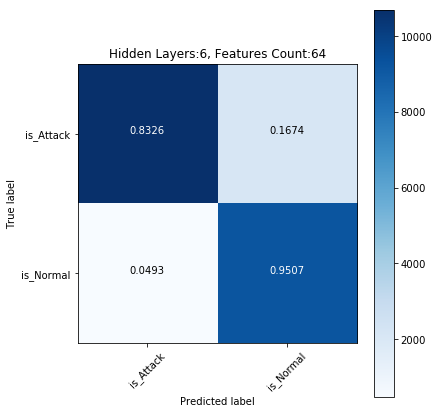

In [16]:
plot(actual_value = Train.actual_value, pred_value = Train.pred_value)